<a href="https://colab.research.google.com/github/arthurcarvalhoc/bach_choral_harmony_eda/blob/main/An%C3%A1lise_Explorat%C3%B3ria_dos_Dados_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise Exploratória dos Dados
Grupo:
- Rafael de Lima Pacheco Silva
- Carlos André Batista
- Arthur Carvalho

In [22]:
!rm jsbach*.*
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00298/jsbach_chorals_harmony.zip
!unzip -o *.zip 

--2022-10-20 14:33:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/00298/jsbach_chorals_harmony.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42966 (42K) [application/x-httpd-php]
Saving to: ‘jsbach_chorals_harmony.zip’

jsbach_chorals_harm 100%[===================>]  41.96K   140KB/s    in 0.3s    

2022-10-20 14:33:03 (140 KB/s) - ‘jsbach_chorals_harmony.zip’ saved [42966/42966]

Archive:  jsbach_chorals_harmony.zip
  inflating: jsbach_chorals_harmony.data  
  inflating: __MACOSX/._jsbach_chorals_harmony.data  
  inflating: jsbach_chorals_harmony.names  


In [ ]:
!pip install pandas numpy sklearn sklearn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Informações do Dataset
Dataset e suas informações extraídos de:
https://archive.ics.uci.edu/ml/datasets/Bach+Choral+Harmony

***
Attribute Information:
1. Choral ID: corresponding to the file names from (Bach Central).
2. Event number: index (starting from 1) of the event inside the chorale.

3-14. Pitch classes: YES/NO depending on whether a given pitch is present.
Pitch classes/attribute correspondence is as follows:
C -> 3
C#/Db -> 4
D -> 5
...
B -> 14

15. Bass: Pitch class of the bass note
16. Meter: integers from 1 to 5. Lower numbers denote less accented events,higher numbers denote more accented events.
17. Chord label: Chord resonating during the given event. 
***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
from sklearn.preprocessing import OrdinalEncoder

plt.style.use("ggplot")
rcParams['figure.figsize'] = (12,  6)

## Visão Geral do Dataset

In [3]:
column_names = ['choral_id','event_number','3','4','5','6','7','8','9','10','11','12','13','14','bass_pitch','meter','label']
feature_cols = ['3','4','5','6','7','8','9','10','11','12','13','14','bass_pitch','meter']

In [4]:
df = pd.read_csv("jsbach_chorals_harmony.data",header=None,names=column_names)

In [5]:
df.head()

,choral_id,event_number,3,4,5,6,7,8,9,10,11,12,13,14,bass_pitch,meter,label
0,000106b_,1,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
1,000106b_,2,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,5,C_M
2,000106b_,3,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,2,C_M
3,000106b_,4,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
4,000106b_,5,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,2,F_M


Removendo colunas que são apenas identificadores, como o `choral_id` e `event_number`

In [6]:
df = df.drop(columns=['choral_id','event_number'])

- O dataset contém 5665 eventos, e 15 colunas. Sendo 14 delas de features e 1 o label do acorde para ser predito.
- Todas as features com exceção da coluna `meter` são strings, o que já mostra que será necessário utilizar alguma forma de encoding para representação delas no modelo
- Não há dados faltantes no dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   3           5665 non-null   object
 1   4           5665 non-null   object
 2   5           5665 non-null   object
 3   6           5665 non-null   object
 4   7           5665 non-null   object
 5   8           5665 non-null   object
 6   9           5665 non-null   object
 7   10          5665 non-null   object
 8   11          5665 non-null   object
 9   12          5665 non-null   object
 10  13          5665 non-null   object
 11  14          5665 non-null   object
 12  bass_pitch  5665 non-null   object
 13  meter       5665 non-null   int64 
 14  label       5665 non-null   object
dtypes: int64(1), object(14)
memory usage: 664.0+ KB


3762 entradas do total de 5665 do dataset são dados duplicados. Isso é um comportamento esperado dada a natureza dos dados, já que um acorde tende a ser definido pela presença das mesmas frequências.

In [8]:
df.duplicated().sum()

3762

## Análise do Label

O label conta com 102 possíveis valores categóricos, sendo assim um problema multiclasse com uma quantidade alta de classes

In [9]:
df.label.nunique()

102

Além do alto número de classes, o que eleva bastante a complexidade do problema, as classes estão bastante desbalanceadas como mostra o gráfico de frequências abaixo. 

Isso já sugere que será necessário avaliar o desempenho de algoritmos de balanceamento de classes para o treinamento do modelo.

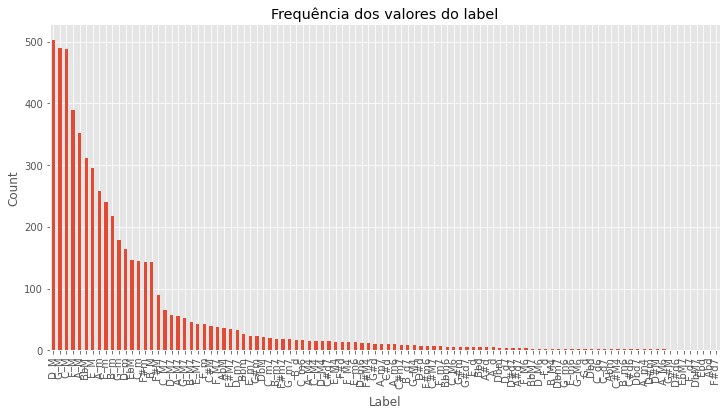

In [10]:
df.label.value_counts().plot(kind="bar")
plt.title("Frequência dos valores do label")
plt.xlabel("Label")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

Como os dados do label são categóricos, para o pré-processamento será necessário utilizar o `OrdinalEncoder` do scikit-learn ou similar.

## Análise das Features

Para as análises das features, será realizado o encoding das variáveis categóricas para que seja possível realizar análises de correlação, distribuição, etc.

- Para as features de frequência (YES|NO), os dados serão convertidos em valores binários 0 e 1
- Para a feature bass_pitch será atribuido um valor ordinal para cada uma dos 16 possíveis valores
- A feature meter não sofrerá alteração pois já está no formato `int`
- Será feito um encoding do target para um valor ordinal para cada um dos 102 possíveis valores.

In [11]:
encoder = OrdinalEncoder()

In [12]:
encoded_df = pd.DataFrame(encoder.fit_transform(df),columns=feature_cols+['label'])

In [13]:
encoded_df.head()

,3,4,5,6,7,8,9,10,11,12,13,14,bass_pitch,meter,label
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,2.0,81.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,4.0,35.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,1.0,35.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,2.0,81.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,1.0,81.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f581885ba50>,
      dtype=object)

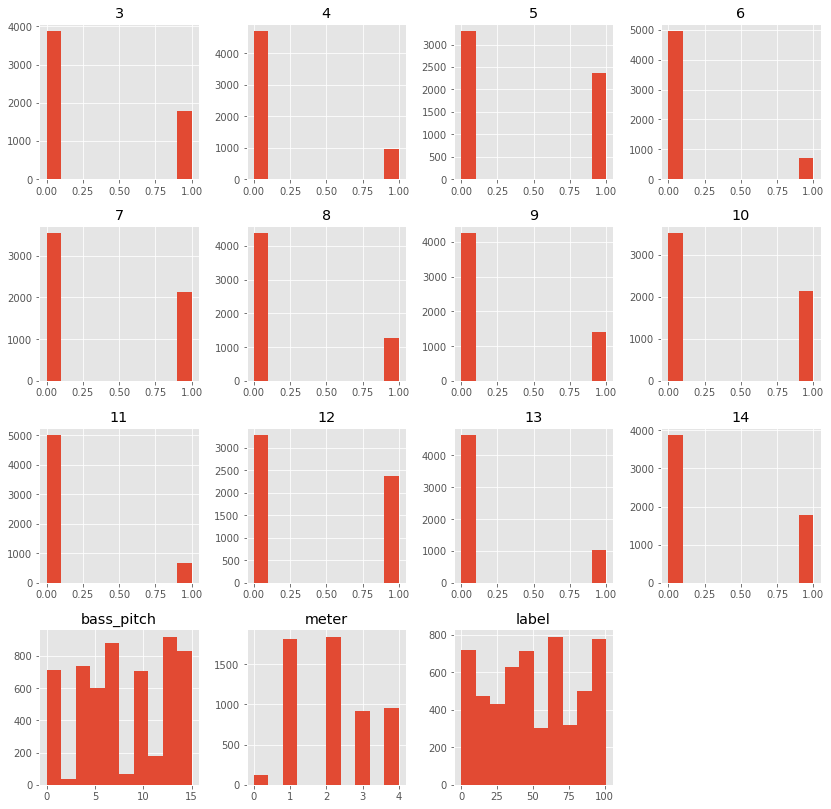

In [14]:
encoded_df.hist(figsize=(14,14))